# SVD w/Normalizer 

### Importing Libraries

In [1]:
from keras import backend as K
from keras import regularizers
import nregularizer
import numpy as np
from gensim_download import pickle_rw
from keras.layers import Dense
from keras.models import Sequential
import matplotlib.pyplot as plt
import plotly.plotly as py
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import numpy.linalg

from numpy.linalg import det

from numpy.linalg import inv

import sympy as sympy

import pandas as pd
%matplotlib inline
import seaborn as sns; sns.set()

from sympy import Matrix
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot



Using TensorFlow backend.


### Defining Functions

In [2]:
def make_dict(vocab, vectors):
    """Make dictionary of vocab and vectors"""
    return {vocab[i]: vectors[i] for i in range(len(vocab))}


def vocab_train_test(embedding, lg1, lg2, lg1_vocab):
    """Create training and test vocabularies"""
    if embedding == 'zeroshot':
        with open('../data/zeroshot/transmat/data/' +
                  'OPUS_en_it_europarl_train_5K.txt') as f:
            vocab_train = [(_.split(' ')[0], _.split(' ')[1])
                           for _ in f.read().split('\n')[:-1]]
        with open('../data/zeroshot/transmat/data/' +
                  'OPUS_en_it_europarl_test.txt') as f:
            vocab_test = [(_.split(' ')[0], _.split(' ')[1])
                          for _ in f.read().split('\n')[:-1]]

    elif embedding in ['fasttext_random', 'fasttext_top']:
        embedding, split = embedding.split('_')
        lg1_lg2, lg2_lg1 = pickle_rw((lg1 + '_' + lg2, 0),
                                     (lg2 + '_' + lg1, 0), write=False)
        # T = Translation, R = Reverse (translated and then translated back)
        # Create vocab from 2D translations
        vocab_2D = []
        for lg1_word in lg1_vocab:
            # Translate lg1_word
            if lg1_word in lg1_lg2:
                lg1_word_T = lg1_lg2[lg1_word]

                # Check if translated word (or lowercase) is in lg2_lg1
                if lg1_word_T in lg2_lg1.keys():
                    lg1_word_R = lg2_lg1[lg1_word_T]
                elif lg1_word_T.lower() in lg2_lg1.keys():
                    lg1_word_T = lg1_word_T.lower()
                    lg1_word_R = lg2_lg1[lg1_word_T]
                else:
                    lg1_word_R = None

                # Check if lg1_word and lg1_word_R are equal (lowercase)
                if lg1_word_R:
                    if lg1_word.lower() == lg1_word_R.lower():
                        vocab_2D.append((lg1_word, lg1_word_T))
        print('length of '+ lg1+'-'+ lg2+ ' vocab: '+str(len(vocab_2D)))

        #Create Train/Test vocab

        if split == 'random':
            sample = np.random.choice(len(vocab_2D), 6500, replace=False)
            vocab_train = np.asarray(vocab_2D)[sample[:5000]].tolist()
            vocab_test = np.asarray(vocab_2D)[sample[5000:]].tolist()
        elif split == 'top':
            sample = np.random.choice(range(1400), 1400, replace=False)
            vocab_train = np.asarray(vocab_2D)[:1000, :].tolist()
            vocab_test = np.asarray(vocab_2D)[:400, :].tolist()
        else:
            pass

        # if split == 'random':
        #     sample = np.random.choice(len(vocab_2D), 900, replace=False)
        #     vocab_train = np.asarray(vocab_2D)[sample[:700]].tolist()
        #     vocab_test = np.asarray(vocab_2D)[sample[700:]].tolist()
        # elif split == 'top':
        #     sample = np.random.choice(range(900), 900, replace=False)
        #     vocab_train = np.asarray(vocab_2D)[:700, :].tolist()
        #     vocab_test = np.asarray(vocab_2D)[:200, :].tolist()
        # else:
        #     pass

    return vocab_train, vocab_test


def vectors_train_test(vocab_train, vocab_test):
    """Create training and test vectors"""
    X_train, y_train = zip(*[(lg1_dict[lg1_word], lg2_dict[lg2_word])
                             for lg1_word, lg2_word in vocab_train])
    X_test, y_test = zip(*[(lg1_dict[lg1_word], lg2_dict[lg2_word])
                           for lg1_word, lg2_word in vocab_test])
    return map(np.asarray, (X_train, X_test, y_train, y_test))




def translation_matrix(X_train, y_train):
    """Fit translation matrix T"""
    #def norm_reg(weight_matrix):
     #   return 0.01 * np.linalg.norm(np.matrix(np.subtract(np.matmul(weight_matrix,weight_matrix.T,np.matmul(weight_matrix.T,weight_matrix))),'fro')
    model = Sequential()
    model.add(Dense(300, use_bias=False, input_shape=(X_train.shape[1],),kernel_regularizer=nregularizer.l3(0.000001)))
    model.compile(loss='mse', optimizer='adam')
    history = model.fit(X_train, y_train, batch_size=128, epochs=20,
                        verbose=False)
    T = model.get_weights()[0]

    T = np.matrix(T)

    M = np.multiply(np.matrix(T),100)

    T_norm, T_normed = normalize(M)

    D = np.linalg.det(M)
    
    I = inv(T)
    
    Fr_norm = np.linalg.norm(np.matrix(np.subtract(np.matmul(T,T.getH()),np.matmul(T.getH(),T))),'fro')

    print ("Determinant:"+str(D))
    
    print ("Fr_norm:"+str(Fr_norm))

    if np.array_equal(np.around(np.matmul(T_normed,T_normed.getH())), np.around(np.matmul(T_normed.getH(),T_normed))) == True:
        tf = "True"
    else:
        tf = "False"

    return model, history, T, D, tf, I, M

def translation_accuracy(X_test, y_test):
    """Get predicted matrix 'yhat' using 'T' and find translation accuracy"""
    # yhat
    yhat = X.dot(T)
    count = 0
    for i in range(len(y_test)):
        if yhat[i,:].all() == y_test[i,:].all():
            count = count + 1
    accuracy = count/len(y_test)*100
    return accuracy

def svd(T):
    """Perform SVD on the translation matrix 'T' """
    U, s, Vh = numpy.linalg.svd(T, full_matrices=False )
    return U, s, Vh

def T_svd_EDA(s):
    """Perform SVD on the translation matrix 'T' """
    plt.hist(s, bins='auto', range = (0,1),normed = 1)
    plt.show()




def normalize(matrix):
    """Normalize the rows of a matrix"""
    matrix_norm = np.linalg.norm(matrix, axis=1)
    matrix_normed = matrix / np.repeat(matrix_norm, matrix.shape[1]). \
        reshape(matrix.shape)
    return matrix_norm, matrix_normed


def translation_results(X, y, vocab, M, lg2_vectors, lg2_vocab):
    """X, y, vocab - The training or test data that you want results for
    T - The translation matrix
    lg2_vectors, lg2_vocab - Foreign language used to find the nearest neighbor
    """

    # Data Prep on Inputs
    X_word, y_word = zip(*vocab)
    X_norm, X_normed = normalize(X)
    y_norm, y_normed = normalize(y)
    lg2_vectors_norm, lg2_vectors_normed = normalize(lg2_vectors)

    # yhat
    yhat = X.dot(M)
    yhat_norm, yhat_normed = normalize(yhat)

    #X_norm = normalize(X)


    # Nearest Neighbors
    neg_cosine = -yhat_normed.dot(lg2_vectors_normed.T)
    ranked_neighbor_indices = np.argsort(neg_cosine, axis=1)

    # Nearest Neighbor
    nearest_neighbor_indices = ranked_neighbor_indices[:, 0]
    yhat_neighbor = lg2_vectors[nearest_neighbor_indices, :]
    yhat_neighbor_norm, yhat_neighbor_normed = normalize(yhat_neighbor)
    yhat_neighbor_word = np.asarray(lg2_vocab)[nearest_neighbor_indices]

    # Results DF
    cols = ['X_norm', 'y_norm', 'yhat_norm', 'yhat_neighbor_norm',
            'X_word', 'y_word', 'yhat_neighbor_word']
    results_df = pd.DataFrame({'X_norm': X_norm,
                               'y_norm': y_norm,
                               'yhat_norm': yhat_norm,
                               'yhat_neighbor_norm': yhat_neighbor_norm,
                               'X_word': X_word,
                               'y_word': y_word,
                               'yhat_neighbor_word': yhat_neighbor_word,})
    results_df = results_df[cols]
    results_df['neighbor_correct'] = results_df.y_word == \
        results_df.yhat_neighbor_word

    return yhat_norm


def T_norm_EDA(results_df):
    """Plot result norms side-by-side"""
    test_size = results_df.shape[0]
    test_accuracy = round(results_df.neighbor_correct.mean(), 2)

    print('Test Accuracy: '+str(test_accuracy)+'\n')

    plot_data = ['X_norm', 'y_norm', 'yhat_norm', 'yhat_neighbor_norm']
    # f, ax = plt.subplots(len(plot_data), sharex=True, sharey=True,
    #                      figsize=(10, 10))
    # for i, d in enumerate(plot_data):
    #     ax[i].hist(results_df[d], bins=100)
    #     ax[i].axis('off')
    #     title = '{}: mean={}, std={}'.format(d, round(results_df[d].mean(), 2), round(results_df[d].std(), 2))
    #     ax[i].set_title(title)
    # f.subplots_adjust(hspace=0.7)
    # plt.savefig('../images/' + lg1 + '_' + lg2 + '_' + embedding +
    #             '_T_norm.png')
    # plt.close('all')
    return


def T_pca_EDA(T):
    """PCA on matrix T"""
    T_ss = StandardScaler().fit_transform(T)
    pca = PCA().fit(T_ss)
    n = pca.n_components_

    # plt.figure(figsize=(10, 6))
    # plt.xlim((0, n))
    # plt.ylim((0, 1))
    # plt.plot(range(n + 1), [0] + np.cumsum(pca.explained_variance_ratio_).
    #          tolist())
    # plt.plot(range(n + 1), np.asarray(range(n + 1)) / n)
    # plt.xlabel('Number of Eigenvectors')
    # plt.ylabel('Explained Variance')
    # plt.savefig('../images/' + lg1 + '_' + lg2 + '_' + embedding +
    #             '_T_isotropy.png')
    # plt.close('all')

    isotropy = (1 - sum(np.cumsum(pca.explained_variance_ratio_) * 1 / n)) / .5
    return isotropy


def T_report_results(embedding, lg1, lg2, lg1_vectors, lg2_vectors,
                     X_train, X_test, D, results_df, isotropy):
    md = '## ' + lg1.title() + ' to ' + lg2.title() + ' ' + \
        embedding.title() + '  \n'
    md += '- ' + lg1.title() + ' Vocabulary Size = ' + \
        '{:,.0f}'.format(lg1_vectors.shape[0]) + '  \n'
    md += '- ' + lg1.title() + ' Embedding Length = ' + \
        '{:,.0f}'.format(lg1_vectors.shape[1]) + '  \n'
    md += '- ' + lg2.title() + ' Vocabulary Size = ' + \
        '{:,.0f}'.format(lg2_vectors.shape[0]) + '  \n'
    md += '- ' + lg2.title() + ' Embedding Length = ' + \
        '{:,.0f}'.format(lg2_vectors.shape[1]) + '  \n'
    md += '- Train Size = ' + '{:,.0f}'.format(X_train.shape[0]) + '  \n'
    md += '- Test Size = ' + '{:,.0f}'.format(X_test.shape[0]) + '  \n'
    md += '- Determinant = ' + '{:,.0f}'.format(D) + '  \n'

    md += '- <b>Test Accuracy = ' + \
        '{:,.1%}'.format(results_df.neighbor_correct.mean()) + '</b>  \n\n'



    md += '#### Test L2 Norms  \n'
    md += '- X_norm: L2 norms for ' + lg1.title() + ' test vectors  \n'
    md += '- y_norm: L2 norms for ' + lg2.title() + ' test vectors  \n'
    md += '- yhat_norm: L2 norms for X.dot(T) test vectors ' + \
        '(T = translation matrix)  \n'
    md += '- yhat_neighbor norm: L2 norms for nearest neighbor' + \
        'to X.dot(T) in y test vectors  \n'
    md += '![](../images/' + lg1 + '_' + lg2 + '_' + embedding + \
        '_T_norm.png)  \n\n'

    md += '#### Translation Matrix Isotropy  \n'
    md += '- Isotropy = ' + '{:,.1%}'.format(isotropy) + '  \n'
    md += '![](../images/' + lg1 + '_' + lg2 + '_' + embedding + \
        '_T_isotropy.png)  \n\n'

    return md

### Main Function ( with SVD stats )

In [6]:
if __name__ == '__main__':
    # Manually set list of translations (embedding, lg1, lg2)
    translations = [#('fasttext_random', 'en', 'ru'),
                    ('fasttext_top', 'en', 'en'),
                    ('fasttext_top', 'en', 'ru'),
                    #('fasttext_random', 'en', 'de'),
                    ('fasttext_top', 'en', 'de'),
                    #('fasttext_random', 'en', 'es'),
                    ('fasttext_top', 'en', 'es'),
                    #('fasttext_random', 'en', 'zh-CN'),
                    ('fasttext_top', 'en', 'zh-CN'),
                    ('fasttext_top', 'en', 'ja'),
        
        
                     #('fasttext_random', 'ru', 'en'),
                    ('fasttext_top', 'ru', 'en'),
                    #('fasttext_random', 'ru', 'es'),
                    ('fasttext_top', 'ru', 'ru'),
                    ('fasttext_top', 'ru', 'de'),
                    
                    ('fasttext_top', 'ru', 'es'),
                    #('fasttext_random', 'ru', 'zh-CN'),
                    ('fasttext_top', 'ru', 'zh-CN'),
                    #('fasttext_random', 'ru', 'de'),
                    ('fasttext_top', 'ru', 'ja'),
                    
        
        
                    #('fasttext_random', 'de', 'en'),
                    ('fasttext_top', 'de', 'en'),
                    #('fasttext_random', 'de', 'es'),
                    ('fasttext_top', 'de', 'ru'), 
                    #('fasttext_random', 'de', 'ru'),
                    ('fasttext_top', 'de', 'de'),
                    ('fasttext_top', 'de', 'es'),
                    
                    #('fasttext_random', 'de', 'zh-CN'),
                    ('fasttext_top', 'de', 'zh-CN'),
                    ('fasttext_top', 'de', 'ja'),
        
        
                    #('fasttext_random', 'es', 'en'),
                    ('fasttext_top', 'es', 'en'),
                    #('fasttext_random', 'es', 'de'),
                    ('fasttext_top', 'es', 'ru'),
                    ('fasttext_top', 'es', 'de'),
                    #('fasttext_random', 'es', 'ru'),
                    ('fasttext_top', 'es', 'es'),
                    #('fasttext_random', 'es', 'zh-CN'),
                    ('fasttext_top', 'es', 'zh-CN'),
                    ('fasttext_top', 'es', 'ja'),
        
                
        
                    #('fasttext_random', 'zh-CN', 'en'),
                    ('fasttext_top', 'zh-CN', 'en'),
                    #('fasttext_random', 'zh-CN', 'es'),
                    ('fasttext_top', 'zh-CN', 'ru'),
                    ('fasttext_top', 'zh-CN', 'de'),
                    ('fasttext_top', 'zh-CN', 'es'),
                    #('fasttext_random', 'zh-CN', 'ru'),
                    ('fasttext_top', 'zh-CN', 'zh-CN'),
                    #('fasttext_random', 'zh-CN', 'de'),
                    ('fasttext_top', 'zh-CN', 'ja'),
        
                    #('fasttext_random', 'zh-CN', 'en'),
                    ('fasttext_top', 'ja', 'en'),
                    #('fasttext_random', 'zh-CN', 'es'),
                    ('fasttext_top', 'ja', 'ru'),
                    ('fasttext_top', 'ja', 'de'),
                    ('fasttext_top', 'ja', 'es'),
                    #('fasttext_random', 'zh-CN', 'ru'),
                    ('fasttext_top', 'ja', 'zh-CN'),
                    ('fasttext_top', 'ja', 'ja')
                    #('fasttext_random', 'zh-CN', 'de'),
                    

                    ]
   
    s_min_en=[]
    s_max_en=[]
    s_mean_en=[]
    s_median_en=[]
    s_std_en=[]
            
    s1_min_en=[]
    s1_max_en=[]
    s1_mean_en=[]
    s1_median_en=[]
    s1_std_en=[]
        
       
        
    s_min_es=[]
    s_max_es=[]
    s_mean_es=[]
    s_median_es=[]
    s_std_es=[]
            
    s1_min_es=[]
    s1_max_es=[]
    s1_mean_es=[]
    s1_median_es=[]
    s1_std_es=[]
            
       
    s_min_ru=[]
    s_max_ru=[]
    s_mean_ru=[]
    s_median_ru=[]
    s_std_ru=[]
            
    s1_min_ru=[]
    s1_max_ru=[]
    s1_mean_ru=[]
    s1_median_ru=[]
    s1_std_ru=[]
            
       
        
    s_min_de=[]
    s_max_de=[]
    s_mean_de=[]
    s_median_de=[]
    s_std_de=[]
        
    s1_min_de=[]
    s1_max_de=[]
    s1_mean_de=[]
    s1_median_de=[]
    s1_std_de=[]
        
      
        
    s_min_zh=[]
    s_max_zh=[]
    s_mean_zh=[]
    s_median_zh=[]
    s_std_zh=[]
            
    s1_min_zh=[]
    s1_max_zh=[]
    s1_mean_zh=[]
    s1_median_zh=[]
    s1_std_zh=[]

    
    s_min_ja=[]
    s_max_ja=[]
    s_mean_ja=[]
    s_median_ja=[]
    s_std_ja=[]
            
    s1_min_ja=[]
    s1_max_ja=[]
    s1_mean_ja=[]
    s1_median_ja=[]
    s1_std_ja=[]

    
    md = ''
    for translation in translations:
        embedding, lg1, lg2 = translation
        # Vocab/Vectors/Dicts
        lg1_vocab, lg1_vectors, lg2_vocab, lg2_vectors = \
            pickle_rw((lg1 + '_' + embedding.split('_')[0] + '_vocab', 0),
                      (lg1 + '_' + embedding.split('_')[0] + '_vectors', 0),
                      (lg2 + '_' + embedding.split('_')[0] + '_vocab', 0),
                      (lg2 + '_' + embedding.split('_')[0] + '_vectors', 0),
                      write=False)
        lg1_dict = make_dict(lg1_vocab, lg1_vectors)
        lg2_dict = make_dict(lg2_vocab, lg2_vectors)

        print('Translation: '+lg1+'->'+lg2+'\n')

        # Train/Test Vocab/Vectors
        vocab_train, vocab_test = vocab_train_test(embedding, lg1, lg2, lg1_vocab)
        X_train, X_test, y_train, y_test = vectors_train_test(vocab_train,
                                                              vocab_test)
 
        
        # Fit tranlation matrix to training data
        model, history, T, D, tf,I, M = translation_matrix(X_train, y_train)

        print('biggest element:'+str(np.max(T))+'\n')
        
        U,s,Vh = svd(T)
        
        #scaler = MinMaxScaler()
        
        #scaler.fit(s)
        
        #s = scaler.transform(s)
        
        s1 = np.log10(s)
        
        print("min: "+str(min(s))+"\n")
        
        print("max: "+str(max(s))+"\n")
        
        print("mean: "+str(np.mean(s))+"\n")
        
        print("median: "+str(np.median(s))+"\n")
        
        print("std: "+str(np.std(s))+"\n")
        
        
        
        print("min: "+str(min(s1))+"\n")
        
        print("max: "+str(max(s1))+"\n")
        
        print("mean: "+str(np.mean(s1))+"\n")
        
        print("median: "+str(np.median(s1))+"\n")
        
        print("std: "+str(np.std(s1))+"\n")
        
        
        if lg1 == 'en':
            s_min_en.append(min(s))
            s_max_en.append(max(s))
            s_mean_en.append(np.mean(s))
            s_median_en.append(np.median(s))
            s_std_en.append(np.std(s))
            
            s1_min_en.append(min(s1))
            s1_max_en.append(max(s1))
            s1_mean_en.append(np.mean(s1))
            s1_median_en.append(np.median(s1))
            s1_std_en.append(np.std(s1))
        
        if lg1 == 'es':
        
            s_min_es.append(min(s))
            s_max_es.append(max(s))
            s_mean_es.append(np.mean(s))
            s_median_es.append(np.median(s))
            s_std_es.append(np.std(s))
            
            s1_min_es.append(min(s1))
            s1_max_es.append(max(s1))
            s1_mean_es.append(np.mean(s1))
            s1_median_es.append(np.median(s1))
            s1_std_es.append(np.std(s1))
            
        if lg1 == 'ru':
        
            s_min_ru.append(min(s))
            s_max_ru.append(max(s))
            s_mean_ru.append(np.mean(s))
            s_median_ru.append(np.median(s))
            s_std_ru.append(np.std(s))
            
            s1_min_ru.append(min(s1))
            s1_max_ru.append(max(s1))
            s1_mean_ru.append(np.mean(s1))
            s1_median_ru.append(np.median(s1))
            s1_std_ru.append(np.std(s1))
            
        if lg1 == 'de':
        
            s_min_de.append(min(s))
            s_max_de.append(max(s))
            s_mean_de.append(np.mean(s))
            s_median_de.append(np.median(s))
            s_std_de.append(np.std(s))
            
            s1_min_de.append(min(s1))
            s1_max_de.append(max(s1))
            s1_mean_de.append(np.mean(s1))
            s1_median_de.append(np.median(s1))
            s1_std_de.append(np.std(s1))
       
        if lg1 == 'zh-CN':
        
            s_min_zh.append(min(s))
            s_max_zh.append(max(s))
            s_mean_zh.append(np.mean(s))
            s_median_zh.append(np.median(s))
            s_std_zh.append(np.std(s))
            
            s1_min_zh.append(min(s1))
            s1_max_zh.append(max(s1))
            s1_mean_zh.append(np.mean(s1))
            s1_median_zh.append(np.median(s1))
            s1_std_zh.append(np.std(s1))
    
        if lg1 == 'ja':
        
            s_min_ja.append(min(s))
            s_max_ja.append(max(s))
            s_mean_ja.append(np.mean(s))
            s_median_ja.append(np.median(s))
            s_std_ja.append(np.std(s))
            
            s1_min_ja.append(min(s1))
            s1_max_ja.append(max(s1))
            s1_mean_ja.append(np.mean(s1))
            s1_median_ja.append(np.median(s1))
            s1_std_ja.append(np.std(s1))
      
        
        
        
        
#         #print(s)
        
#         plt.hist(s,bins='auto')#bins=50,normed='True',range = (0.0,0.2))
#         #plt.plot(s)
#         plt.show()
        
        

Translation: en->en

length of en-en vocab: 49999


/usr/local/lib/python3.6/site-packages/numpy/linalg/linalg.py:1821: RuntimeWarning:

overflow encountered in det



Determinant:-inf
Fr_norm:10.2898
biggest element:0.2382

min: 0.00218582

max: 1.34457

mean: 0.540926

median: 0.505282

std: 0.346952

min: -2.66039

max: 0.128583

mean: -0.417384

median: -0.296466

std: 0.451284

Translation: en->ru

length of en-ru vocab: 6839
Determinant:-inf
Fr_norm:13.7497
biggest element:0.161448

min: 0.000419862

max: 1.62412

mean: 0.617876

median: 0.580177

std: 0.395351

min: -3.37689

max: 0.210619

mean: -0.363363

median: -0.236455

std: 0.472347

Translation: en->de

length of en-de vocab: 16693
Determinant:-inf
Fr_norm:13.1249
biggest element:0.170534

min: 0.00137132

max: 1.59874

mean: 0.616219

median: 0.587201

std: 0.387703

min: -2.86286

max: 0.203777

mean: -0.360121

median: -0.231217

std: 0.457245

Translation: en->es

length of en-es vocab: 10422
Determinant:inf
Fr_norm:12.1423
biggest element:0.154411

min: 0.00311603

max: 1.43035

mean: 0.597435

median: 0.566932

std: 0.37211

min: -2.5064

max: 0.155441

mean: -0.368144

median: -

Translation: ja->ru

length of ja-ru vocab: 430
Determinant:inf
Fr_norm:24.276
biggest element:0.131916

min: 0.00121758

max: 1.98339

mean: 0.843769

median: 0.80802

std: 0.526829

min: -2.9145

max: 0.297407

mean: -0.223253

median: -0.0925781

std: 0.460103

Translation: ja->de

length of ja-de vocab: 1070
Determinant:inf
Fr_norm:24.1469
biggest element:0.178253

min: 0.000886542

max: 1.9853

mean: 0.837265

median: 0.796007

std: 0.526513

min: -3.0523

max: 0.297826

mean: -0.230205

median: -0.099084

std: 0.470132

Translation: ja->es

length of ja-es vocab: 1258
Determinant:-inf
Fr_norm:24.0589
biggest element:0.183651

min: 0.00170404

max: 1.95071

mean: 0.836934

median: 0.800989

std: 0.52503

min: -2.76852

max: 0.290193

mean: -0.227269

median: -0.0963734

std: 0.457769

Translation: ja->zh-CN

length of ja-zh-CN vocab: 481
Determinant:inf
Fr_norm:24.264
biggest element:0.154249

min: 0.00260631

max: 1.96738

mean: 0.845093

median: 0.805249

std: 0.52633

min: -2.5

## Making List of Lists

In [7]:
s_min = []
s_min.append(s_min_en)
s_min.append(s_min_ru)
s_min.append(s_min_de)
s_min.append(s_min_es)
s_min.append(s_min_zh)
s_min.append(s_min_ja)
s_max = []
s_max.append(s_max_en)
s_max.append(s_max_ru)
s_max.append(s_max_de)
s_max.append(s_max_es)
s_max.append(s_max_zh)
s_max.append(s_max_ja)
s_mean = []
s_mean.append(s_mean_en)
s_mean.append(s_mean_ru)
s_mean.append(s_mean_de)
s_mean.append(s_mean_es)
s_mean.append(s_mean_zh)
s_mean.append(s_mean_ja)
s_median = []
s_median.append(s_median_en)
s_median.append(s_median_ru)
s_median.append(s_median_de)    
s_median.append(s_median_es)
s_median.append(s_median_zh)
s_median.append(s_median_ja)
s_std = []
s_std.append(s_std_en)
s_std.append(s_std_ru)
s_std.append(s_std_de)
s_std.append(s_std_es)
s_std.append(s_std_zh)
s_std.append(s_std_ja)

s1_min = []
s1_min.append(s1_min_en)
s1_min.append(s1_min_ru)
s1_min.append(s1_min_de)
s1_min.append(s1_min_es)
s1_min.append(s1_min_zh)
s1_min.append(s1_min_ja)
s1_max = []
s1_max.append(s1_max_en)
s1_max.append(s1_max_ru)
s1_max.append(s1_max_de)
s1_max.append(s1_max_es)
s1_max.append(s1_max_zh)
s1_max.append(s1_max_ja)
s1_mean = []
s1_mean.append(s1_mean_en)
s1_mean.append(s1_mean_ru)
s1_mean.append(s1_mean_de)
s1_mean.append(s1_mean_es)
s1_mean.append(s1_mean_zh)
s1_mean.append(s1_mean_ja)
s1_median = []
s1_median.append(s1_median_en)
s1_median.append(s1_median_ru)
s1_median.append(s1_median_de)
s1_median.append(s1_median_es)
s1_median.append(s1_median_zh)
s1_median.append(s1_median_ja)
s1_std = []
s1_std.append(s1_std_en)
s1_std.append(s1_std_ru)
s1_std.append(s1_std_de)
s1_std.append(s1_std_es)
s1_std.append(s1_std_zh)
s1_std.append(s1_std_ja)
    

## Converting List of Lists to Pandas DF

In [8]:
#s_min_df = pd.DataFrame(s_min)
#s_min_df.columns =['en', 'ru', 'de', 'es', 'zh-CN']
s_min_df =pd.DataFrame(s_min,index = ['en', 'ru', 'de', 'es', 'zh-CN','ja'], columns =['en', 'ru', 'de', 'es', 'zh-CN','ja'])
s_max_df =pd.DataFrame(s_max,index = ['en', 'ru', 'de', 'es', 'zh-CN','ja'], columns =['en', 'ru', 'de', 'es', 'zh-CN','ja'])
s_mean_df =pd.DataFrame(s_mean,index = ['en', 'ru', 'de', 'es', 'zh-CN','ja'], columns =['en', 'ru', 'de', 'es', 'zh-CN','ja'])
s_median_df =pd.DataFrame(s_median,index = ['en', 'ru', 'de', 'es', 'zh-CN','ja'], columns =['en', 'ru', 'de', 'es', 'zh-CN','ja'])
s_std_df =pd.DataFrame(s_std,index = ['en', 'ru', 'de', 'es', 'zh-CN','ja'], columns =['en', 'ru', 'de', 'es', 'zh-CN','ja'])


s1_min_df =pd.DataFrame(s1_min,index = ['en', 'ru', 'de', 'es', 'zh-CN','ja'], columns =['en', 'ru', 'de', 'es', 'zh-CN','ja'])
s1_max_df =pd.DataFrame(s1_max,index = ['en', 'ru', 'de', 'es', 'zh-CN','ja'], columns =['en', 'ru', 'de', 'es', 'zh-CN','ja'])
s1_mean_df =pd.DataFrame(s1_mean,index = ['en', 'ru', 'de', 'es', 'zh-CN','ja'], columns =['en', 'ru', 'de', 'es', 'zh-CN','ja'])
s1_median_df =pd.DataFrame(s1_median,index = ['en', 'ru', 'de', 'es', 'zh-CN','ja'], columns =['en', 'ru', 'de', 'es', 'zh-CN','ja'])
s1_std_df =pd.DataFrame(s1_std,index = ['en', 'ru', 'de', 'es', 'zh-CN','ja'], columns =['en', 'ru', 'de', 'es', 'zh-CN','ja'])



In [9]:
s_min_df = np.transpose(s_min_df)
s_max_df = np.transpose(s_max_df)
s_mean_df = np.transpose(s_mean_df)
s_median_df = np.transpose(s_median_df)
s_std_df = np.transpose(s_std_df)


s1_min_df = np.transpose(s1_min_df)
s1_max_df = np.transpose(s1_max_df)
s1_mean_df = np.transpose(s1_mean_df)
s1_median_df = np.transpose(s1_median_df)
s1_std_df = np.transpose(s1_std_df)


In [10]:
cmap = sns.diverging_palette(10, 130, sep=20, as_cmap=True)


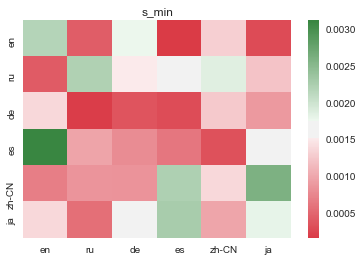

In [11]:
s_min_hm = sns.heatmap(s_min_df,cmap=cmap)
title = s_min_hm.set_title('s_min')

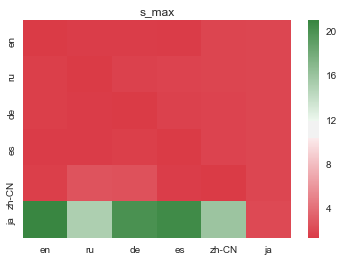

In [12]:
s_max_hm = sns.heatmap(s_max_df,cmap=cmap)
title = s_max_hm.set_title('s_max')

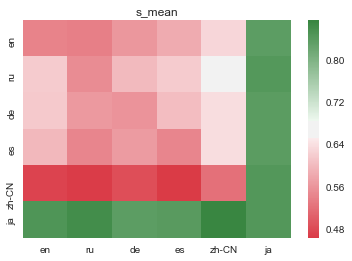

In [13]:
s_mean_hm = sns.heatmap(s_mean_df,cmap=cmap)
title = s_mean_hm.set_title('s_mean')

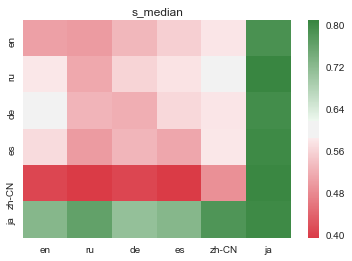

In [14]:
s_median_hm = sns.heatmap(s_median_df,cmap=cmap)
title = s_median_hm.set_title('s_median')

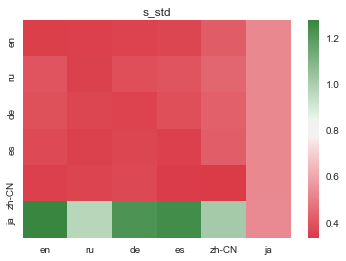

In [15]:
s_std_hm = sns.heatmap(s_std_df,cmap=cmap)
title = s_std_hm.set_title('s_std')

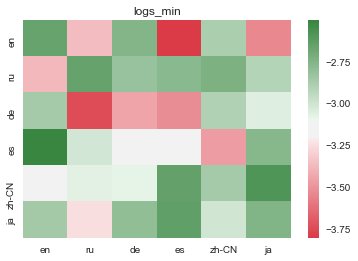

In [16]:
s1_min_hm = sns.heatmap(s1_min_df,cmap=cmap)
title = s1_min_hm.set_title('logs_min')

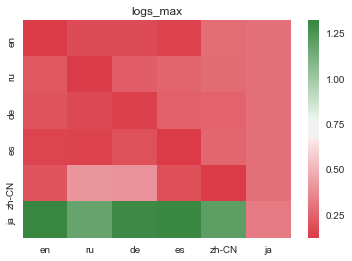

In [17]:
s1_max_hm = sns.heatmap(s1_max_df,cmap=cmap)
title = s1_max_hm.set_title('logs_max')

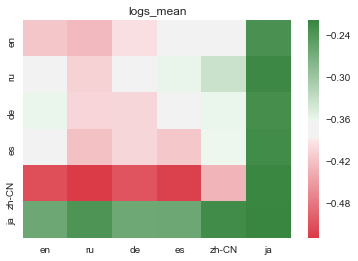

In [18]:
s1_mean_hm = sns.heatmap(s1_mean_df,cmap=cmap)
title = s1_mean_hm.set_title('logs_mean')

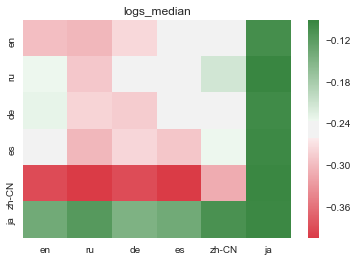

In [19]:
s1_median_hm = sns.heatmap(s1_median_df,cmap=cmap)
title = s1_median_hm.set_title('logs_median')

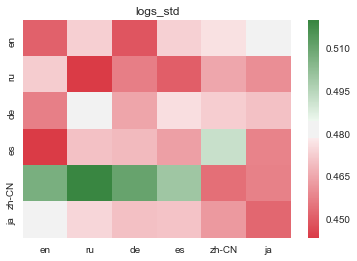

In [20]:
s1_std_hm = sns.heatmap(s1_std_df,cmap=cmap)
title = s1_std_hm.set_title('logs_std')